In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Dependencies
import os
import matplotlib.pyplot as plt
import random
import pickle
import numpy as np
import tensorflow as tf
import random

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Input, Embedding, Dropout, LSTM, Dense, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Import Functions

In [ ]:
!wget https://raw.githubusercontent.com/GargPriyanshu1112/Image-Caption-Generator/main/helper_functions.py

from helper_functions import get_all_captions, load_doc, get_sample

--2022-08-19 07:57:44--  https://raw.githubusercontent.com/GargPriyanshu1112/Image-Caption-Generator/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105 (1.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   1.08K  --.-KB/s    in 0s      

2022-08-19 07:57:44 (9.23 MB/s) - ‘helper_functions.py’ saved [1105/1105]



# Setting up Paths

In [ ]:
TRAIN_IMGS_FILEPATH = "/content/drive/MyDrive/Project/captions/Flickr_8k.trainImages.txt"
TEST_IMGS_FILEPATH = "/content/drive/MyDrive/Project/captions/Flickr_8k.testImages.txt"
IMAGES_DIR = "/content/drive/MyDrive/Project/images"
MAPPINGS_FILEPATH = "/content/drive/MyDrive/Project/mappings.txt"
IMAGE_FEATURES_FILEPATH = "/content/drive/MyDrive/Project/features.pkl"
GLOVE_EMBEDDINGS_FILEPATH = "/content/drive/MyDrive/Project/glove.6B.200d.txt"

# Get Training Captions

In [ ]:
def get_images(filepath):
    # Get the contents of the file
    content = load_doc(filepath, 'r')
    
    # Get the list of train images
    images = content.split('\n')[:-1]
    
    return images

In [ ]:
def load_captions(filepath, image_names):
    discriptions = dict() # Will store image-captions mapping

    # Get mappings
    mappings = load_doc(filepath, 'r')
        
    for line in mappings.split('\n'):
        if len(line) < 1:
            continue
            
        img_name, img_caption = line.split('\t')
                
        if img_name in image_names:
            if img_name not in discriptions:
                discriptions[img_name] = [img_caption]
            else:
                discriptions[img_name].append(img_caption)

    return discriptions 

In [ ]:
# Get the list of train images
train_image_names = get_images(TRAIN_IMGS_FILEPATH)

# Load train image-captions mapping
mappings_train = load_captions(MAPPINGS_FILEPATH, train_image_names)

print(f"There are {len(mappings_train)*5} training captions, 5 for each train image.")

There are 30000 training captions, 5 for each train image.


# Get Training Image Features

In [ ]:
def get_image_features(filepath, image_names):
    # Load features
    with open(filepath, 'rb') as f:
        all_features = pickle.load(f)
    
    # Get features for specific images
    features = {img_name: all_features[img_name]  for img_name in image_names}
    
    return features

In [ ]:
# Get train image features
train_image_features = get_image_features(IMAGE_FEATURES_FILEPATH, train_image_names)

print(f"There are {len(train_image_features)} train images.")

There are 6000 train images.


# Create a Text Vectorizer

In [ ]:
def create_text_vectorizer(lines):    
    # Get text vectorizer
    text_vectorizer = TextVectorization(max_tokens=1750) 
    text_vectorizer.adapt(lines)
    
    return text_vectorizer

In [ ]:
# Get all captions
all_captions = get_all_captions(MAPPINGS_FILEPATH)

# Get text vectorizer
text_vectorizer = create_text_vectorizer(all_captions)

# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()

# Get vocabulary size
vocab_size = len(words_in_vocab)

print(f"No. of words in vocabulary: {vocab_size}\n")

No. of words in vocabulary: 1750



# Find Length of Longest Train Caption

In [ ]:
def max_length(mappings):
    lengths = [] # Will store lengths of train captions
    for captions_list in mappings.values():
        for line in captions_list:
            lengths.append(len(line.split()))
            
    return max(lengths)

In [ ]:
# Get length of the longest caption
max_len = max_length(mappings_train)

print(f"Length of the longest train caption: {max_len}")

Length of the longest train caption: 34


# Word Embeddings

We will be using `pretrained GloVe embeddings` representing words in `200`-dimensional vectors.

In [ ]:
# Create a dictionary that will hold each word and its respective vector
embed_dict = dict()

with open(GLOVE_EMBEDDINGS_FILEPATH, 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], 'float32')
    embed_dict[word] = vector
f.close()

In [ ]:
# Get 200-dimensional dense vector for each word in the vocabulary

embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# For each word in the vocabulary
for i, word in enumerate(text_vectorizer.get_vocabulary()):
  # Get the embedding vector
  embedding_vector = embed_dict.get(word)

  # Save the embedding vector to the embedding matrix
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

# Model Engineering

In [ ]:
def make_model(vocab_size, max_len):
    image_input = Input(shape=(2048, ), name="Image_Input")
    i1 = Dropout(rate=0.5, name="Dropout_1")(image_input)
    i2 = Dense(units=256, activation="relu", name="Dense_1")(i1)

    
    caption_input = Input(shape=(max_len, ), name="Sequence_Input")
    c1 = Embedding(input_dim=vocab_size, output_dim=200, mask_zero=True)(caption_input)
    c2 = Dropout(rate=0.5, name="Dropout_2")(c1)
    c3 = LSTM(units=256)(c2)


    x = add([i2, c3])
    x = Dense(units=256, activation="relu", name="Dense_2")(x)
    outputs = Dense(units=vocab_size, activation="softmax", name="Output_layer")(x)

    return Model(inputs=[image_input, caption_input], outputs=outputs)

In [ ]:
# Get the model
model = make_model(vocab_size, max_len)

# Set weights for the Embedding Layer
model.layers[2].set_weights([embedding_matrix])

# Freeze the Embedding Layer
model.layers[2].trainable = False

In [ ]:
# Get model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_Input (InputLayer)    [(None, 34)]         0           []                               
                                                                                                  
 Image_Input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      350000      ['Sequence_Input[0][0]']         
                                                                                                  
 Dropout_1 (Dropout)            (None, 2048)         0           ['Image_Input[0][0]']            
                                                                                              

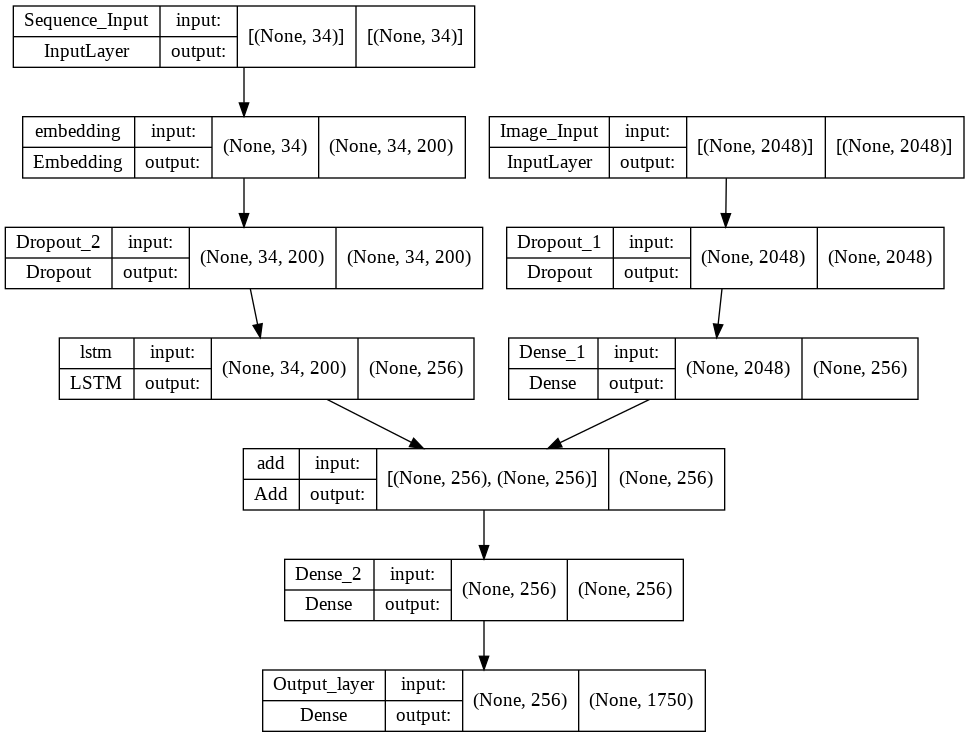

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

# Compile the Model

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Create Input-Output Sequence Pairs

The model will be provided the first word and the image as input and will generate the next word. Then the first two words will be provided to the model with the same image to generate the next word. This is how the model will be trained.


  X1 (features) |           X2 (text sequence)                 |  y (next word)
----------------|----------------------------------------------|-----------
     image      |  startseq,                                   |  little
     image      |  startseq, little,                           |  girl
     image      |  startseq, little, girl,                     |  running
     image      |  startseq, little, girl, running,            |  in
     image      |  startseq, little, girl, running, in,        |  field
     image      |  startseq, little, girl, running, in, field, |  endseq


In [ ]:
def data_generator(mappings, image_features, text_vectorizer, max_len, vocab_size):
    X1, X2, y = [], [], []
    n = 0
    # Loop over every image
    while True:
        for image, captions_list in mappings.items():
            n = n+1
            # Retrieve image features
            image = image_features[image][0]

            for caption in captions_list:
                # Encode the caption
                seq = text_vectorizer(caption)

                # Split the sequence into multiple X, y pairs (as in above eg.)
                for i in range(1, len(seq)):
                    # Split into input-ouput pair
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]

                    # One-hot encode output sequence such that 0 value for all word
                    # position except for the actual word position which has a value of 1.
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store
                    X1.append(image)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            if n == 32:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = [], [], []
                n = 0

# Train the Model

In [ ]:
EPOCHS = 50
TRAIN_STEPS = len(mappings_train) // 32

# Run epochs manually and save after each epoch
for i in range(EPOCHS):
    # Create the data generator
    generator = data_generator(mappings_train, 
                               train_image_features,
                               text_vectorizer,
                               max_len,
                               vocab_size) 
    
    # Fit for each epoch
    model.fit(generator, 
              epochs=1,
              steps_per_epoch=TRAIN_STEPS,
              verbose=1)
    
    # Save the model
    model.save("model_" + str(i) + ".h5")

 86/187 [============>.................] - ETA: 4:29 - loss: 2.2562 - accuracy: 0.4154

# Load the Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/f/model_43.h5")

# Generate Captions for Test Images

In [ ]:
def int_to_vocab(text_vectorizer):
    int_to_vocab = dict() # Will store integer to word mapping
    
    # Get vocabulary
    vocab = text_vectorizer.get_vocabulary()
    
    for idx in range(len(vocab)):
        int_to_vocab[idx] = vocab[idx]
        
    return int_to_vocab

In [ ]:
def get_image_features(filepath):
    # Load the model
    model = InceptionV3()
    # Restructure the model (remove the last layer)
    model = Model(inputs=model.input, outputs=model.layers[-2].output)
    
    # Get image
    image = load_img(filepath, target_size=(299, 299))
    # Get image in array form
    input_arr = img_to_array(image)
    # Reshape input image array
    input_arr = np.expand_dims(input_arr, axis=0)
    # Prepare the image for VGG model
    input_arr = preprocess_input(input_arr)
    # Get features
    features = model.predict(input_arr, verbose=0)
        
    return features 

In [ ]:
def get_image_description(max_len, text_vectorizer, model, image, int_to_vocab):
    text = "startseq" # The input sequence starts with a start-token
    
    # Iterate over whole length of sequence
    for i in range(max_len):
        # Vectorize input sequence
        seq = text_vectorizer(text)
        
        # Pad the vectorized sequence
        seq = pad_sequences([seq], maxlen=max_len)
        
        # Predict the next word
        next_word = np.argmax(model.predict([image, seq], verbose=0)) # and use of argmax as it predicts position
        
        # Map the integer to word
        next_word = int_to_vocab[next_word]
        
        # Stop if we cannot map the word
        if next_word is None:
            break
        
        # Append the predicted word to the input to get the next sequence
        text = text + ' ' + next_word
        
        # Stop if we predict the end of the sequence
        if next_word == "endseq":
            break
    
    text = ' '.join(text.split()[1: -1])

    return text

In [ ]:
def get_random_test_image(images_fpath):
  # Get images
  images_list = get_images(images_fpath)
  # Select a random image
  image = random.choice(images_list)

  return image 

In [ ]:
def generate_caption(image_name):
  # Load and prepare the image
  image_features = get_image_features(os.path.join(IMAGES_DIR, image_name))
  # Generate the caption
  caption = get_image_description(max_len, text_vectorizer, model, image_features, int_to_vocab)

  # Display the image and caption
  image = plt.imread(os.path.join(IMAGES_DIR, image_name))
  plt.imshow(image)
  plt.axis(False)
  plt.show()
  print(f"\nCaption: {caption}")

In [ ]:
# Get integer-to-word dictionary
int_to_vocab = int_to_vocab(text_vectorizer)

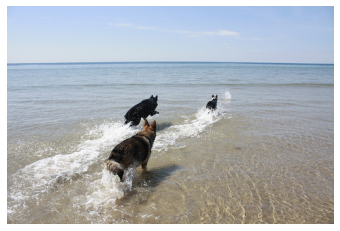


Caption: three dogs run into the water


In [ ]:
# Get a random test image
image_name = get_random_test_image(TEST_IMGS_FILEPATH)
# Generate caption
generate_caption(image_name)

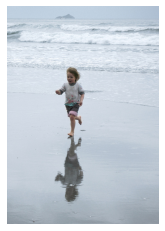


Caption: young girl running on wet path


In [ ]:
# Get a random test image
image_name = get_random_test_image(TEST_IMGS_FILEPATH)
# Generate caption
generate_caption(image_name)

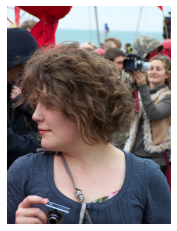


Caption: woman with black hair is looking at the camera


In [ ]:
# Get a random test image
image_name = get_random_test_image(TEST_IMGS_FILEPATH)
# Generate caption
generate_caption(image_name)

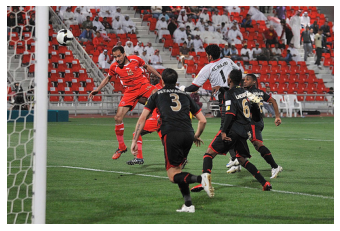


Caption: two football players are fighting for the ball


In [ ]:
# Get a random test image
image_name = get_random_test_image(TEST_IMGS_FILEPATH)
# Generate caption
generate_caption(image_name)

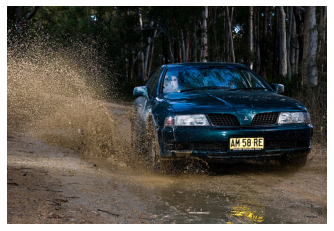


Caption: vehicle drives down the road


In [ ]:
# Get a random test image
image_name = get_random_test_image(TEST_IMGS_FILEPATH)
# Generate caption
generate_caption(image_name)